In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from tqdm import tqdm
import ampds_preprocessing
#import utils
from time import time
import pickle
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
with open('arrays/df.pickle', 'rb') as fp:
    df = pickle.load(fp)
# divide los dataframes entre agregados y desagregados
individual = df.loc[:, df.columns.get_level_values('name')!='WHE']
aggregate = df.loc[:, df.columns.get_level_values('name')=='WHE']

In [8]:
D = np.load('arrays/D.npy')
X = np.load('arrays/X.npy')

# Problema a resolver
Se intenta resolver un problema similar al del paper https://arxiv.org/pdf/1704.07308.pdf. El problema es el siguiente:
$$min_A ||X - DA||_{F}^2$$

$$\text{ s.t. $A_{i,j}>0$ $\forall i,j$}$$

- $D$ (Matriz de diccionario): Es una matriz cuyas columnas son las bases del consumo de energeia electrico (se espera poder estimar el consumo sea una combinación lineal de estos vectores).

- $X$ (Matriz de datos a proyectar): Es una matriz en la que cada columna representa el consumo electrico de que se quiere proyectar sobre las columnas de $D$.

## Implementación
Se implementa mediante apgd. El tipo de aceleración que se elige es ADAM.

In [11]:
names = list(ampds_preprocessing.FULL_NAME.keys())
names.remove('WHE')
sum_current_elec = np.empty((len(names), X.shape[1]))
mask = np.zeros(D.shape[1], dtype=int)
for i, s in enumerate(names):
    # Mascara para tener solo el electrodomestico de interes
    mask[(individual.columns.get_level_values('name')==s)[0:D.shape[1]]] = i
n_mask = len(names)

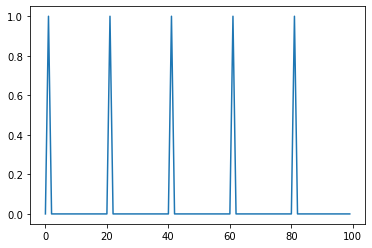

In [18]:
plt.plot((mask==1)[:100])

In [20]:
len(np.unique(mask))

20

In [35]:
U[i, mask==0].shape

(581,)

In [46]:
from get_arrays import get_Q, get_U, get_G, get_H
Q = get_Q(mask)
U = get_U(mask, X.shape[1])

In [52]:
np.logspace(-3, 2, 6)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])

In [54]:
A_s2k = dict()
losses_s2k = dict()
for beta in np.logspace(-3, 2, 6):
    print(f'BETA: {beta}')
    G = get_G(X, U, beta)
    H = get_G(D, Q, beta)
    t1 = time()
    A_s2k[beta], cost, losses_s2k[beta] = adam_pgd(H, G, early_stopping=100)
    t2 = time()
    print(f'Tiempo: {t2-t1:.1f}')
    print('\n'*4)

BETA: 0.001
[iter:0]	36890968.00
[iter:1000]	1265417.38
[iter:2000]	1184886.75
[iter:3000]	1147263.50
[iter:4000]	1123113.25
[iter:5000]	1106389.38
[iter:6000]	1094724.62
[iter:7000]	1086515.62
[iter:8000]	1080575.50
[iter:9000]	1076125.12
[iter:10000]	1072718.88
[iter:11000]	1070059.38
[iter:12000]	1067959.25
[iter:13000]	1066268.50
[iter:14000]	1064870.38
[iter:15000]	1063693.38
[iter:16000]	1062687.12
[iter:17000]	1061813.75
[iter:18000]	1061043.62
[iter:19000]	1060360.12
[iter:20000]	1059754.12
[iter:21000]	1059217.38
[iter:22000]	1058740.75
[iter:23000]	1058317.00
[iter:24000]	1057939.00
[iter:25000]	1057601.12
[iter:26000]	1057300.12
[iter:27000]	1057032.75
[iter:28000]	1056796.50
[iter:29000]	1056589.00
[iter:30000]	1056408.38
[iter:31000]	1056260.25
[iter:32000]	1056140.88
[iter:33000]	1056042.00
[iter:34000]	1055958.75
[iter:35000]	1055888.75
[iter:36000]	1055830.25
[iter:37000]	1055782.88
[iter:38000]	1055745.50
[iter:39000]	1055716.38
[iter:40000]	1055693.25
[iter:41000]	105

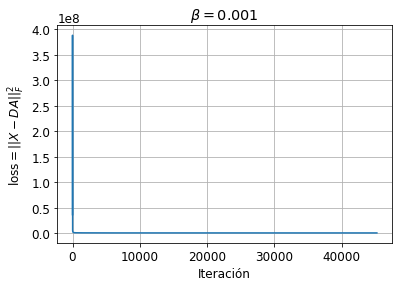

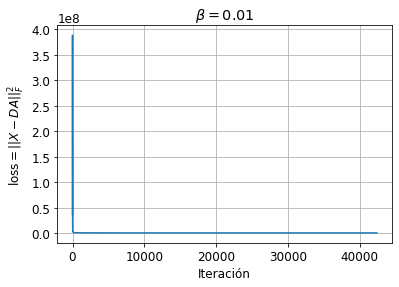

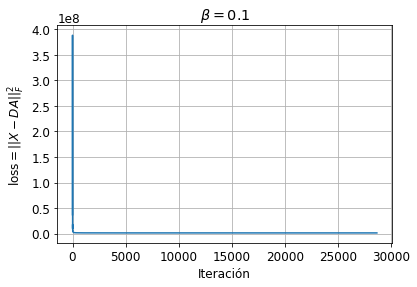

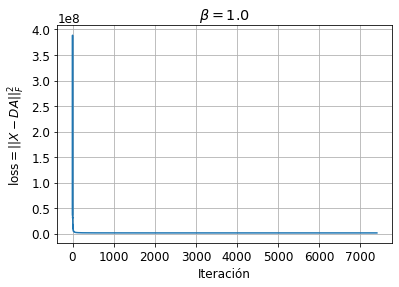

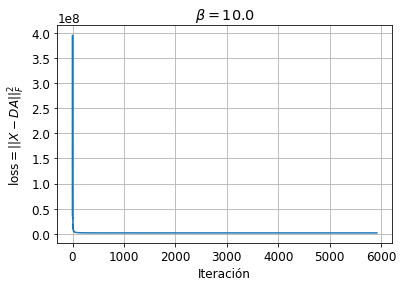

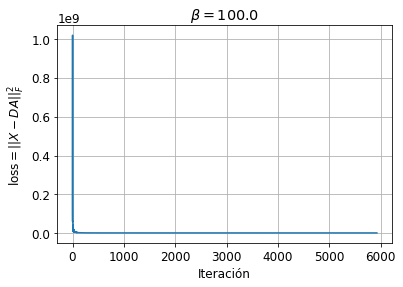

In [65]:
from utils import plot_loss
for (_, A), (beta,loss) in zip(A_s2k.items(), losses_s2k.items()):
    loss = np.array(loss)
    np.save(f'arrays/A_s2k_reg_{beta}.npy', A)
    np.save('arrays/losses_s2k_reg_{beta}.npy', loss)
    plot_loss(loss, title=rf'$\beta={beta}$')

In [66]:
!nvidia-smi

Sun Dec 27 17:21:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:37:00.0 Off |                    0 |
| N/A   61C    P0    44W / 250W |   2869MiB / 12198MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------